In [1]:
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import matplotlib.pyplot as pl  # Matplotlib is a scientific plotting package.

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline
pl.rcParams.update({'font.size': 11})          # Set the standard font size of the plots to 11pt.
pl.rcParams.update({'figure.figsize': [13,5]}) # Set the standard figure size.

In [24]:
nx = 256
ny = 128

Lx = 1e7
Ly = 5e6

u0 = 0.

g = 9.81
H = 200.
a = 6.37e6
lat = 45.
Omega = 7.292e-5
f0 = 2.*Omega*np.sin(np.deg2rad(lat))
beta = (2./a)*Omega*np.cos(np.deg2rad(lat))

dx = Lx / nx
dy = Ly / ny

x = np.arange(0, Lx, dx)
y = np.arange(0, Ly, dy)

xx, yy = np.meshgrid(x, y)

Psi0 = u0*yy

h_dist = 1.
L_dist = 2e6
x_sigma = L_dist/6.
h0 = np.exp(-( (xx-Lx/2.)**2 + (yy-Ly/2.)**2) / (2.*x_sigma**2))
h0 = h_dist*h0/np.max(h0)
Psi = Psi0 + g/f0*h0

kkk = 2.*np.pi/Lx * np.arange(nx//2+1)
lll = 2.*np.pi/Ly * np.arange(ny//2+1)
llll = np.zeros(ny)
llll[0:ny//2+1] = lll[:]
for i in range(1,ny//2+1):
    llll[-i] = -llll[i]


u = -np.fft.irfft( 1j*lll[:, np.newaxis]*np.fft.rfft(Psi, axis=0), axis=0 )
v =  np.fft.irfft( 1j*kkk[np.newaxis, :]*np.fft.rfft(Psi, axis=1), axis=1 )

h = f0/g*Psi

dPsidx = np.fft.irfft( 1j*kkk[np.newaxis, :]*np.fft.rfft(Psi, axis=1), axis=1 )
dPsidy = np.fft.irfft( 1j*lll[:, np.newaxis]*np.fft.rfft(Psi, axis=0), axis=0 )

d2Psidx2 = np.fft.irfft( -kkk[np.newaxis, :]**2*np.fft.rfft(Psi, axis=1), axis=1 )
d2Psidy2 = np.fft.irfft( -lll[:, np.newaxis]**2*np.fft.rfft(Psi, axis=0), axis=0 )

q0 = d2Psidx2 + d2Psidy2 + beta*yy - f0**2/(g*H)*Psi

In [25]:
c0 = f0**2/(g*H)

def invert_q(q_in):
    q_fft = np.fft.rfft2(q_in - beta*yy)
    Psi_fft = q_fft / ( - kkk[np.newaxis,:]**2  - llll[:,np.newaxis]**2 - c0 )
    return np.fft.irfft2(Psi_fft)

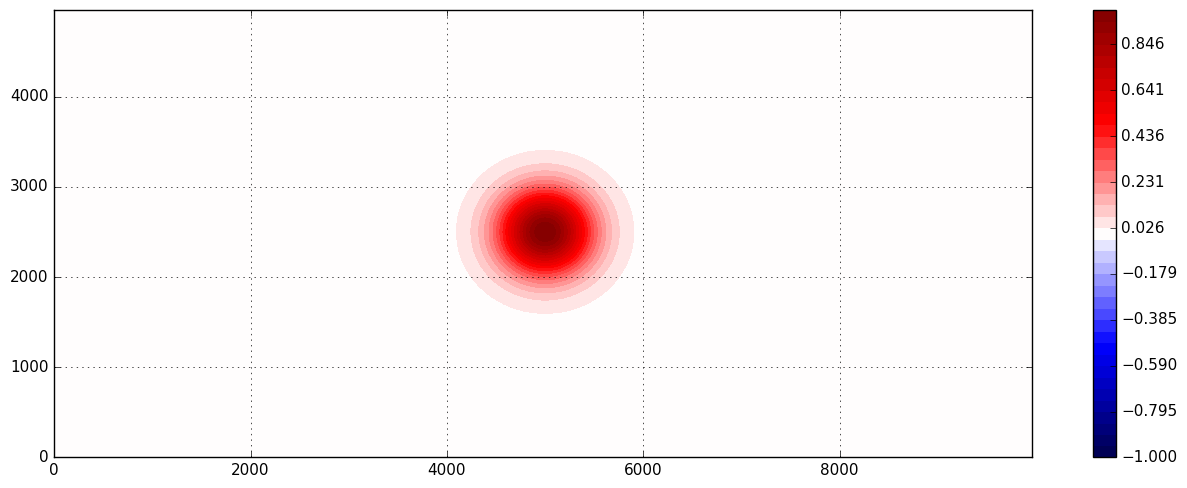

In [26]:
Psi = invert_q(q0)
u = -np.gradient(Psi, dy, axis=0)
v =  np.gradient(Psi, dx, axis=1)
h = f0/g*Psi
h_range = np.linspace(-1., 1., 40)
pl.contourf(x/1000, y/1000, h, h_range, cmap=pl.cm.seismic)
pl.colorbar()
#pl.streamplot(x/1000, y/1000, u, v, color='k')
pl.grid()
pl.tight_layout()

In [33]:
dt = 1800.
runtime = 30 * 86400.
nsteps = round(runtime / dt)

q = q0.copy()
t = 0.
for n in range(nsteps):
    Psi = invert_q(q)

    u = -np.fft.irfft( 1j*lll[:, np.newaxis]*np.fft.rfft(Psi, axis=0), axis=0 )
    v =  np.fft.irfft( 1j*kkk[np.newaxis, :]*np.fft.rfft(Psi, axis=1), axis=1 )
    dqdt = -u*np.fft.irfft( 1j*kkk[np.newaxis, :]*np.fft.rfft(q, axis=1), axis=1 ) \
           -v*np.fft.irfft( 1j*lll[:, np.newaxis]*np.fft.rfft(q, axis=0), axis=0 )
    q += dt*dqdt 
    t += dt

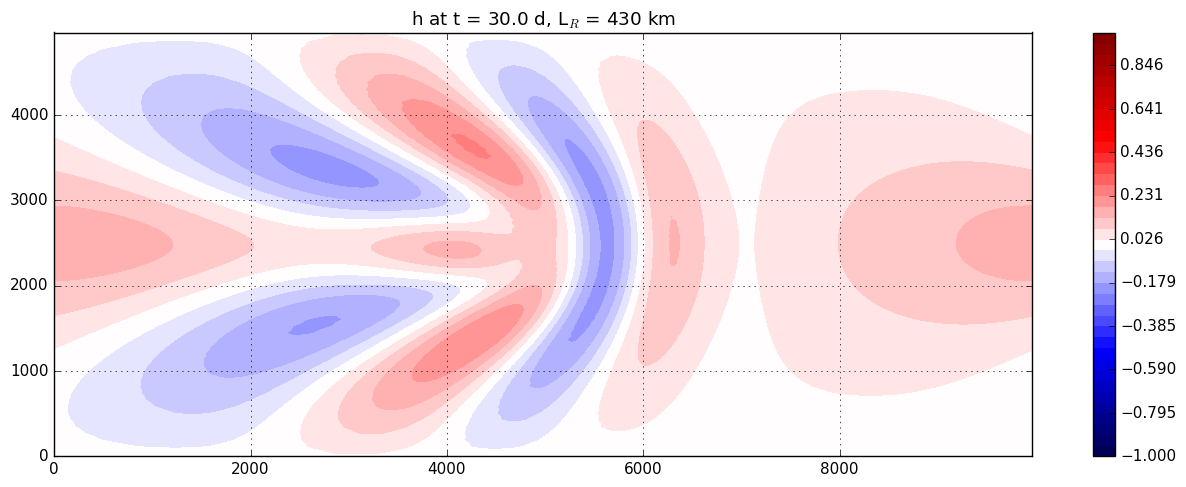

In [45]:
Psi = invert_q(q)
u = -np.fft.irfft( 1j*lll[:, np.newaxis]*np.fft.rfft(Psi, axis=0), axis=0 )
v =  np.fft.irfft( 1j*kkk[np.newaxis, :]*np.fft.rfft(Psi, axis=1), axis=1 )
h = f0/g*Psi
pl.contourf(x/1000, y/1000, h, h_range, cmap=pl.cm.seismic)
pl.colorbar()
#pl.contour(x/1000, y/1000, h0, colors='k')
#pl.streamplot(x/1000, y/1000, u, v, color='k')
pl.grid()
pl.title('h at t = {0:.1f} d, L$_R$ = {1:.0f} km'.format(t/86400., (g*H)**.5/f0 / 1000))
pl.tight_layout()

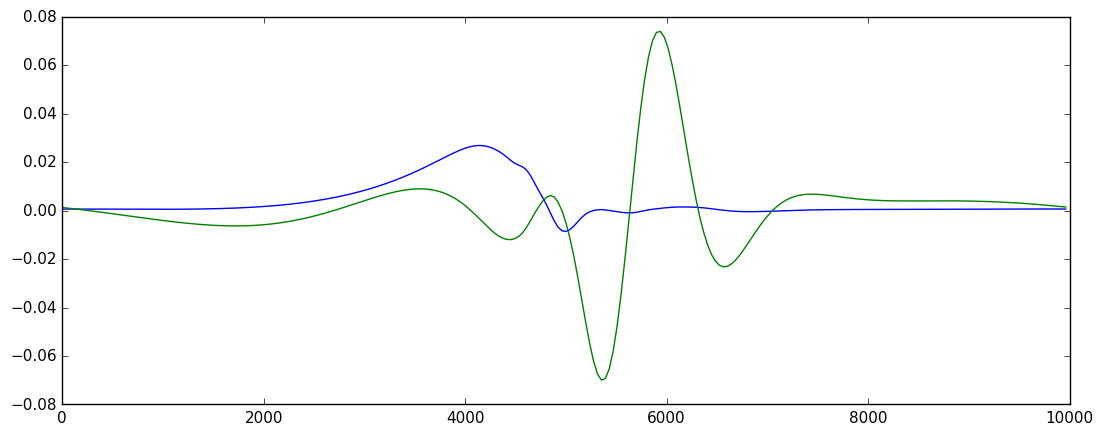

In [35]:
pl.figure()
pl.plot(x/1000, u[ny//2,:])
pl.plot(x/1000, v[ny//2,:])

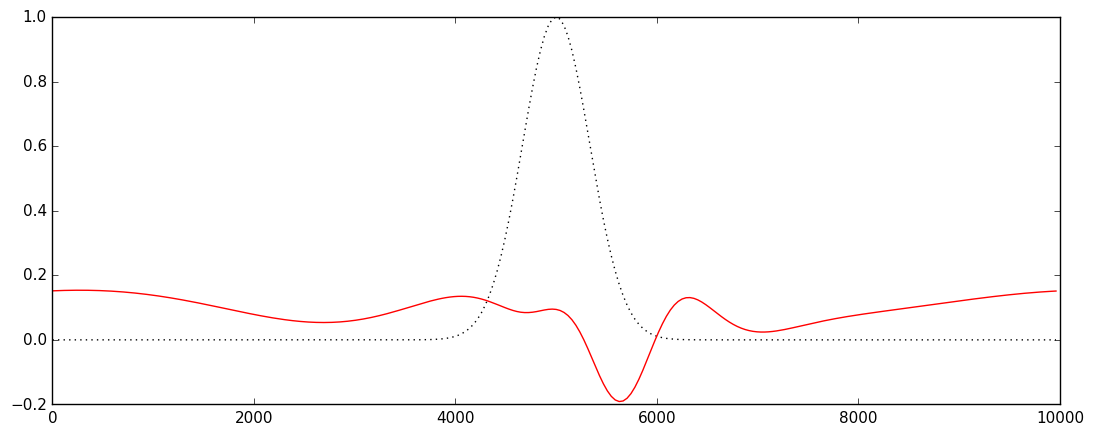

In [36]:
pl.figure()
pl.plot(x/1000, h0[ny//2,:], 'k:')
pl.plot(x/1000, h [ny//2,:], 'r-')

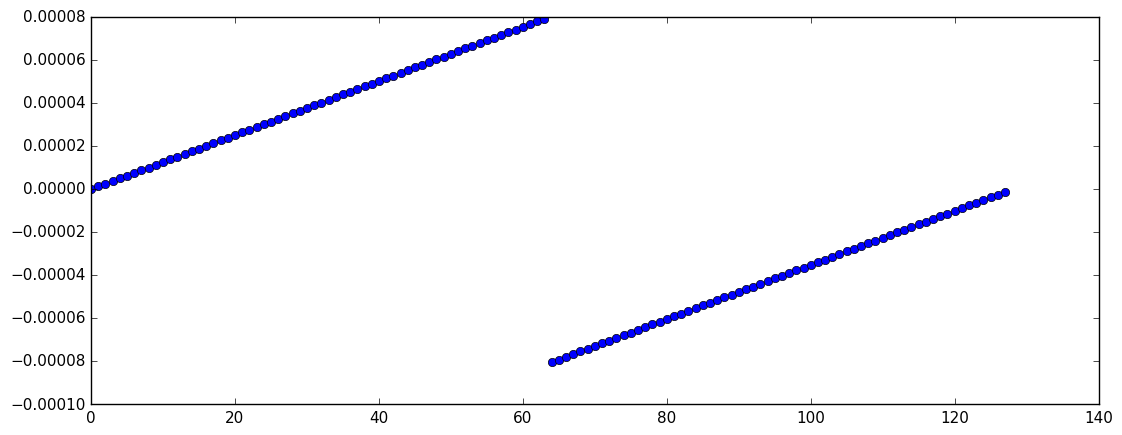

In [32]:
pl.plot(llll, 'bo')